In this notebook, we will finally create predictive features using the logs we cleaned on notebook 2.2. Our focus, for now, will be prediction using an aggregate non-temporal representation of each student.

Throughout the notebook, we will start with the import of logs and remaining tables that we consider to be relevant for feature engineering and extraction.

#### 1. Importing the relevant packages, setting global variables and importing the relevant files

In [1]:
#import libs
import pandas as pd
import numpy as np
from pandas.tseries.offsets import *

#viz related tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns

#tqdm to monitor progress
from tqdm.notebook import tqdm, trange
tqdm.pandas(desc="Progress")

#time related features
from datetime import timedelta
from copy import copy, deepcopy

#starting with other tools
sns.set()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#to save
import xlsxwriter

In [2]:
#global variables that may come in handy
#course threshold sets the % duration that will be considered (1 = 100%)
duration_threshold = [0.1, 0.25, 0.33, 0.5, 1]

#colors for vizualizations
nova_ims_colors = ['#BFD72F', '#5C666C']

#standard color for student aggregates
student_color = '#474838'

#standard color for course aggragates
course_color = '#1B3D2F'

#standard continuous colormap
standard_cmap = 'viridis_r'

#Function designed to deal with multiindex and flatten it
def flattenHierarchicalCol(col,sep = '_'):
    '''converts multiindex columns into single index columns while retaining the hierarchical components'''
    if not type(col) is tuple:
        return col
    else:
        new_col = ''
        for leveli,level in enumerate(col):
            if not level == '':
                if not leveli == 0:
                    new_col += sep
                new_col += level
        return new_col

In [3]:
#loading student log data 
student_logs = pd.read_csv('../Data/Modeling Stage/NovaIMS_cleaned_logs.csv',
                           dtype = {
                                   'cd_curso': float,
                                   'userid': float,
                                   'courseid': float,
                                   },
                                   parse_dates = ['time']).drop('Unnamed: 0', axis = 1) #logs

#converting to object
student_logs['userid'], student_logs['cd_curso'], student_logs['courseid'] = student_logs['userid'].astype(object), student_logs['cd_curso'].astype(object), student_logs['courseid'].astype(object)

#other tables with support information
support_table = pd.read_csv('../Data/Nova_IMS_support_table.csv',
                             dtype = {
                                 'cd_curso' : float,
                                 'courseid' : float,
                                 'userid' : float,
                                 'assign_id': float,
                             }, parse_dates = ['startdate', 'end_date']).drop('Unnamed: 0', axis = 1)

#converting to object
support_table['userid'], support_table['cd_curso'], support_table['courseid'], support_table['assign_id'] = support_table['userid'].astype(object), support_table['cd_curso'].astype(object), support_table['courseid'].astype(object), support_table['assign_id'].astype(object)

#save tables 
class_list = pd.read_csv('../Data/Modeling Stage/NovaIMS_class_duration.csv', 
                         dtype = {
                                   'cd_curso': float,
                                   'courseid': float,                                   
                                   },
                        parse_dates = ['Start Date','End Date', 'cuttoff_point']).rename(columns = {'cuttoff_point' : 'Week before start'})

#converting to object
class_list['cd_curso'], class_list['courseid'] = class_list['cd_curso'].astype(object), class_list['courseid'].astype(object)

#targets tables 
targets_table = pd.read_csv('../Data/Modeling Stage/Nova_IMS_targets_table.csv',
                           dtype = {
                                   'cd_curso': float,
                                   'userid': float,
                                   'courseid': float,
                                   },).drop('Unnamed: 0', axis = 1)

#converting to float
targets_table['userid'], targets_table['courseid'] = targets_table['userid'].astype(object), targets_table['courseid'].astype(object)

We'll start with the general verification of the different datasets we've imported. 

**Starting with the targets table, which includes all valid student-course logs with Final-Grade.**

In [4]:
#get info
targets_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cd_curso      15289 non-null  float64
 1   nm_curso_pt   15289 non-null  object 
 2   courseid      15289 non-null  object 
 3   ds_discip_pt  15289 non-null  object 
 4   semestre      15289 non-null  object 
 5   userid        15289 non-null  object 
 6   final_mark    15289 non-null  float64
 7   exam_mark     15289 non-null  float64
dtypes: float64(3), object(5)
memory usage: 955.7+ KB


In [5]:
targets_table.describe(include = 'all', datetime_is_numeric = True)

,cd_curso,nm_curso_pt,courseid,ds_discip_pt,semestre,userid,final_mark,exam_mark
count,15289.000000,15289,15289.0,15289,15289,15289.0,15289.000000,15289.000000
unique,NaN,28,251.0,239,6,2305.0,NaN,NaN
top,NaN,Mestrado em Gestão de Informação,200086.0,Business Process Management,S1,3248.0,NaN,NaN
freq,NaN,3338,339.0,356,6216,17.0,NaN,NaN
mean,7284.332330,NaN,NaN,NaN,NaN,NaN,14.911178,14.544688
std,2158.531359,NaN,NaN,NaN,NaN,NaN,3.752871,4.075090
min,859.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,4973.000000,NaN,NaN,NaN,NaN,NaN,14.000000,13.000000
50%,8183.000000,NaN,NaN,NaN,NaN,NaN,16.000000,16.000000
75%,9155.000000,NaN,NaN,NaN,NaN,NaN,17.000000,17.000000


In [6]:
targets_table

,cd_curso,nm_curso_pt,courseid,ds_discip_pt,semestre,userid,final_mark,exam_mark
0,8259.0,Licenciatura em Sistemas e Tecnologias de Info...,100001.0,Álgebra Linear,S1,1544.0,4.0,4.0
1,8259.0,Licenciatura em Sistemas e Tecnologias de Info...,100001.0,Álgebra Linear,S1,1556.0,6.0,9.0
2,9155.0,Licenciatura em Gestão de Informação,100001.0,Álgebra Linear,S1,1564.0,10.0,9.0
3,8259.0,Licenciatura em Sistemas e Tecnologias de Info...,100001.0,Álgebra Linear,S1,3146.0,15.0,15.0
4,9155.0,Licenciatura em Gestão de Informação,100001.0,Álgebra Linear,S1,3178.0,11.0,9.0
...,...,...,...,...,...,...,...,...
15284,4969.0,Pós-Graduação em Digital Enterprise Management,400094.0,Big Data Analytics for Business,T4,7230.0,9.0,9.0
15285,4969.0,Pós-Graduação em Digital Enterprise Management,400094.0,Big Data Analytics for Business,T4,7242.0,14.0,14.0
15286,4969.0,Pós-Graduação em Digital Enterprise Management,400094.0,Big Data Analytics for Business,T4,7243.0,16.0,16.0
15287,4969.0,Pós-Graduação em Digital Enterprise Management,400094.0,Big Data Analytics for Business,T4,7248.0,15.0,15.0


Then, we repeat the same for the list of courses and their respective start and end dates. We know that the number of students attending each course is the number found in the logs. We will need to make further cuts 

In [7]:
class_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   cd_curso              630 non-null    object        
 1   semestre              630 non-null    object        
 2   courseid              630 non-null    object        
 3   Users per course      630 non-null    int64         
 4   Start Date            630 non-null    datetime64[ns]
 5   End Date              630 non-null    datetime64[ns]
 6   Course duration days  630 non-null    float64       
 7   Week before start     630 non-null    datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(1), object(3)
memory usage: 39.5+ KB


In [8]:
class_list.describe(include = 'all', datetime_is_numeric = True)

,cd_curso,semestre,courseid,Users per course,Start Date,End Date,Course duration days,Week before start
count,630.0,630,630.0,630.000000,630,630,630.000000,630
unique,28.0,6,222.0,NaN,NaN,NaN,NaN,NaN
top,9155.0,S2,200187.0,NaN,NaN,NaN,NaN,NaN
freq,50.0,260,13.0,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,22.742857,2020-11-30 16:00:00,2021-03-31 05:20:00,121.555556,2020-11-23 16:00:00
min,NaN,NaN,NaN,1.000000,2020-09-07 00:00:00,2020-11-06 00:00:00,61.000000,2020-08-31 00:00:00
25%,NaN,NaN,NaN,2.000000,2020-09-07 00:00:00,2021-01-22 00:00:00,138.000000,2020-08-31 00:00:00
50%,NaN,NaN,NaN,8.000000,2021-02-08 00:00:00,2021-04-09 00:00:00,138.000000,2021-02-01 00:00:00
75%,NaN,NaN,NaN,30.000000,2021-02-08 00:00:00,2021-06-25 00:00:00,138.000000,2021-02-01 00:00:00
max,NaN,NaN,NaN,178.000000,2021-04-12 00:00:00,2021-06-25 00:00:00,138.000000,2021-04-05 00:00:00


In [9]:
class_list

,cd_curso,semestre,courseid,Users per course,Start Date,End Date,Course duration days,Week before start
0,4281.0,S1,200012.0,15,2020-09-07,2021-01-22,138.0,2020-08-31
1,4281.0,S1,200032.0,10,2020-09-07,2021-01-22,138.0,2020-08-31
2,4281.0,S1,200071.0,3,2020-09-07,2021-01-22,138.0,2020-08-31
3,4281.0,S1,200101.0,65,2020-09-07,2021-01-22,138.0,2020-08-31
4,4281.0,S1,200159.0,65,2020-09-07,2021-01-22,138.0,2020-08-31
...,...,...,...,...,...,...,...,...
625,9435.0,S2,400081.0,17,2021-02-08,2021-06-25,138.0,2021-02-01
626,9435.0,T1,200204.0,11,2020-09-07,2020-11-06,61.0,2020-08-31
627,9435.0,T2,200197.0,6,2020-11-02,2021-01-22,82.0,2020-10-26
628,9435.0,T4,200194.0,1,2021-04-12,2021-06-11,61.0,2021-04-05


We still note a significant presence of courses with small numbers of students. The first step we will take is the removal of all courses whose number of attending students is below 50.

In [10]:
class_list = class_list[class_list['Users per course'] >= 50]

#updating student logs
student_logs = student_logs[student_logs['courseid'].isin(class_list['courseid']) & 
                            student_logs['cd_curso'].isin(class_list['cd_curso']) &
                            student_logs['semestre'].isin(class_list['semestre'])].reset_index(drop = True)

#additionally updating targets_table
targets_table = targets_table[targets_table['courseid'].isin(class_list['courseid']) & 
                              targets_table['cd_curso'].isin(class_list['cd_curso']) &
                              targets_table['semestre'].isin(class_list['semestre'])].reset_index(drop = True)

#additionally updating support_table
support_table = support_table[support_table['courseid'].isin(class_list['courseid']) & 
                              support_table['cd_curso'].isin(class_list['cd_curso']) &
                              support_table['semestre'].isin(class_list['semestre'])].reset_index(drop = True)

class_list.describe(include = 'all', datetime_is_numeric = True)

,cd_curso,semestre,courseid,Users per course,Start Date,End Date,Course duration days,Week before start
count,92.0,92,92.0,92.000000,92,92,92.000000,92
unique,6.0,6,83.0,NaN,NaN,NaN,NaN,NaN
top,9155.0,S1,100068.0,NaN,NaN,NaN,NaN,NaN
freq,28.0,38,2.0,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,90.173913,2020-11-24 08:52:10.434782720,2021-03-26 00:00:00,122.630435,2020-11-17 08:52:10.434782720
min,NaN,NaN,NaN,51.000000,2020-09-07 00:00:00,2020-11-06 00:00:00,61.000000,2020-08-31 00:00:00
25%,NaN,NaN,NaN,67.000000,2020-09-07 00:00:00,2021-01-22 00:00:00,138.000000,2020-08-31 00:00:00
50%,NaN,NaN,NaN,80.500000,2020-11-02 00:00:00,2021-01-22 00:00:00,138.000000,2020-10-26 00:00:00
75%,NaN,NaN,NaN,95.500000,2021-02-08 00:00:00,2021-06-25 00:00:00,138.000000,2021-02-01 00:00:00
max,NaN,NaN,NaN,178.000000,2021-04-12 00:00:00,2021-06-25 00:00:00,138.000000,2021-04-05 00:00:00


In [11]:
targets_table

,cd_curso,nm_curso_pt,courseid,ds_discip_pt,semestre,userid,final_mark,exam_mark
0,8259.0,Licenciatura em Sistemas e Tecnologias de Info...,100001.0,Álgebra Linear,S1,1544.0,4.0,4.0
1,8259.0,Licenciatura em Sistemas e Tecnologias de Info...,100001.0,Álgebra Linear,S1,1556.0,6.0,9.0
2,9155.0,Licenciatura em Gestão de Informação,100001.0,Álgebra Linear,S1,1564.0,10.0,9.0
3,8259.0,Licenciatura em Sistemas e Tecnologias de Info...,100001.0,Álgebra Linear,S1,3146.0,15.0,15.0
4,9155.0,Licenciatura em Gestão de Informação,100001.0,Álgebra Linear,S1,3178.0,11.0,9.0
...,...,...,...,...,...,...,...,...
9117,7512.0,Mestrado em Métodos Analíticos Avançados,200207.0,Modelação e Gestão de Big Data,T4,6293.0,14.0,14.0
9118,7512.0,Mestrado em Métodos Analíticos Avançados,200207.0,Modelação e Gestão de Big Data,T4,6631.0,18.0,18.0
9119,7512.0,Mestrado em Métodos Analíticos Avançados,200207.0,Modelação e Gestão de Big Data,T4,6696.0,0.0,0.0
9120,7512.0,Mestrado em Métodos Analíticos Avançados,200207.0,Modelação e Gestão de Big Data,T4,7590.0,18.0,18.0


In [12]:
student_logs

,cd_curso,semestre,courseid,component,action,target,objecttable,userid,time,CourseFullname,nm_curso_pt,ds_discip_pt
0,9434.0,S1,200165.0,core,viewed,course,NaN,5916.0,2020-09-04 20:45:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
1,9434.0,S1,200165.0,core,viewed,user_profile,user,5916.0,2020-09-04 20:45:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
2,9434.0,S1,200165.0,mod_forum,viewed,course_module,forum,5916.0,2020-09-04 20:45:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
3,9434.0,S1,200165.0,core,viewed,course,NaN,5916.0,2020-09-04 21:03:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
4,9434.0,S1,200165.0,core,viewed,user_list,course,5916.0,2020-09-04 21:03:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
...,...,...,...,...,...,...,...,...,...,...,...,...
2424931,9155.0,S2,100014.0,mod_quiz,viewed,attempt,quiz_attempts,3288.0,2021-06-23 14:46:00,202021 - Base de Dados II - S2,Licenciatura em Gestão de Informação,Base de Dados II
2424932,9155.0,S2,100014.0,mod_quiz,submitted,attempt,quiz_attempts,3288.0,2021-06-23 14:46:00,202021 - Base de Dados II - S2,Licenciatura em Gestão de Informação,Base de Dados II
2424933,9155.0,S2,100014.0,mod_quiz,reviewed,attempt,quiz_attempts,3288.0,2021-06-23 14:46:00,202021 - Base de Dados II - S2,Licenciatura em Gestão de Informação,Base de Dados II
2424934,9155.0,S2,100014.0,mod_quiz,viewed,attempt_summary,quiz_attempts,3288.0,2021-06-23 14:46:00,202021 - Base de Dados II - S2,Licenciatura em Gestão de Informação,Base de Dados II


We'll follow up with taking a closer look logs we cleaned in the previous section. 

In [13]:
student_logs.keys()

Index(['cd_curso', 'semestre', 'courseid', 'component', 'action', 'target',
       'objecttable', 'userid', 'time', 'CourseFullname', 'nm_curso_pt',
       'ds_discip_pt'],
      dtype='object')

In [14]:
student_logs.describe(include = 'all', datetime_is_numeric = True)

,cd_curso,semestre,courseid,component,action,target,objecttable,userid,time,CourseFullname,nm_curso_pt,ds_discip_pt
count,2424936.0,2424936,2424936.0,2424936,2424936,2424936,1439269,2424936.0,2424936,2424936,2424936,2424936
unique,6.0,6,83.0,20,20,37,32,1317.0,NaN,106,6,79
top,9434.0,S1,200165.0,core,viewed,course,resource,6826.0,NaN,202021 - Base de dados / Base de dados I (1000...,Mestrado em Gestão de Informação,Programming for Data Science
freq,681467.0,1076630,78516.0,955401,2310481,923794,465268,10214.0,NaN,74406,681467,85926
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-27 14:55:26.479082752,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-31 00:14:00,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 12:33:00,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-12 21:05:00,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-20 12:02:00,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-24 23:58:00,NaN,NaN,NaN


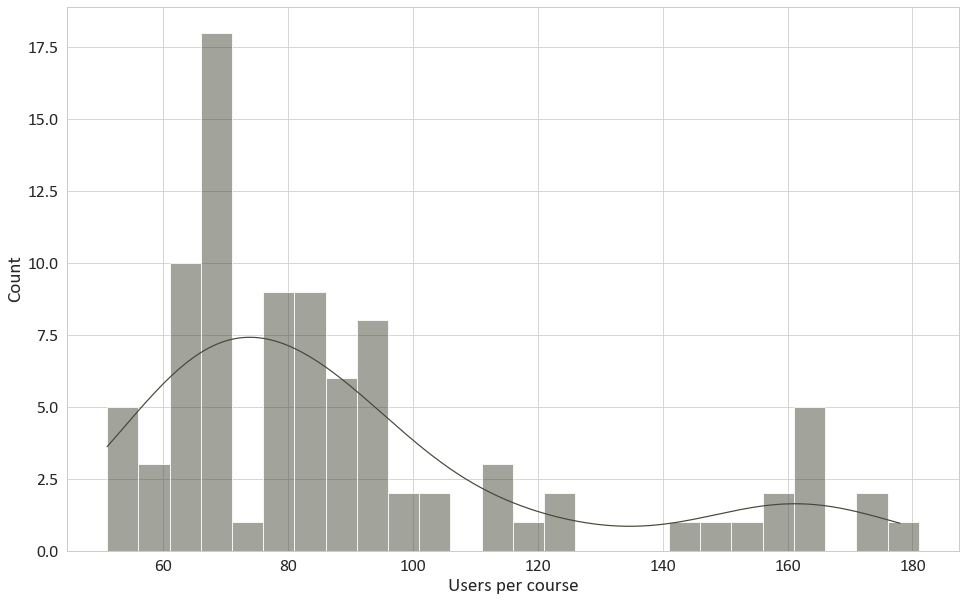

In [15]:
#then we plot an histogram with all courses, we are not interested in keeping courses with a number of students inferior to 10
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(16, 10)}, font_scale=2)
hist4 = sns.histplot(data=class_list, x='Users per course', kde=True, color= student_color, binwidth = 5,)

fig = hist4.get_figure()
fig.savefig('../Images/Nova_students_per_course_bin_5, filtered.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, hist4


Likewise, there is some attention to be found on courses with abnormally high numbers of attending students in a face-to-face context (over 200). We will pay closer attention to those courses.

In [16]:
#create df only with high affluence courses
most_affluent_courses = class_list[class_list['Users per course'] >= 100]

#separate logs accordingly
high_attendance_logs = student_logs[student_logs['courseid'].isin(most_affluent_courses['courseid']) & 
                            student_logs['cd_curso'].isin(most_affluent_courses['cd_curso']) &
                            student_logs['semestre'].isin(most_affluent_courses['semestre'])].reset_index(drop = True)
high_attendance_logs

,cd_curso,semestre,courseid,component,action,target,objecttable,userid,time,CourseFullname,nm_curso_pt,ds_discip_pt
0,9434.0,S1,200165.0,core,viewed,course,NaN,5916.0,2020-09-04 20:45:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
1,9434.0,S1,200165.0,core,viewed,user_profile,user,5916.0,2020-09-04 20:45:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
2,9434.0,S1,200165.0,mod_forum,viewed,course_module,forum,5916.0,2020-09-04 20:45:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
3,9434.0,S1,200165.0,core,viewed,course,NaN,5916.0,2020-09-04 21:03:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
4,9434.0,S1,200165.0,core,viewed,user_list,course,5916.0,2020-09-04 21:03:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
...,...,...,...,...,...,...,...,...,...,...,...,...
866758,9434.0,T4,200194.0,gradereport_user,viewed,grade_report,NaN,6155.0,2021-06-07 20:47:00,202021 - TransformaÃ§Ã£o Digital - Turma TP2 - T4,Mestrado em Gestão de Informação,Transformação Digital
866759,9434.0,T4,200194.0,core,viewed,course,NaN,6155.0,2021-06-07 21:00:00,202021 - TransformaÃ§Ã£o Digital - Turma TP2 - T4,Mestrado em Gestão de Informação,Transformação Digital
866760,7512.0,S2,200167.0,core,viewed,course,NaN,5755.0,2021-05-04 09:38:00,Big Data Analytics (MAA),Mestrado em Métodos Analíticos Avançados,Big Data Analytics
866761,7512.0,T4,200207.0,core,viewed,course,NaN,5755.0,2021-05-04 09:39:00,Big Data Modelling and Management,Mestrado em Métodos Analíticos Avançados,Modelação e Gestão de Big Data


In [17]:
high_attendance_logs.describe(include = 'all', datetime_is_numeric = 'all')

,cd_curso,semestre,courseid,component,action,target,objecttable,userid,time,CourseFullname,nm_curso_pt,ds_discip_pt
count,866763.0,866763,866763.0,866763,866763,866763,519329,866763.0,866763,866763,866763,866763
unique,2.0,6,21.0,17,19,35,28,580.0,NaN,36,2,21
top,9434.0,S1,200179.0,core,viewed,course,quiz_attempts,5730.0,NaN,202021 - Aprendizagem AutomÃ¡tica - S1,Mestrado em Gestão de Informação,Aprendizagem Automática
freq,500646.0,425338,74380.0,335450,811176,321099,147137,7602.0,NaN,74380,500646,74380
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-28 19:09:24.012030720,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-31 00:14:00,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-19 14:29:30,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-27 09:53:00,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-16 08:16:00,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-24 23:58:00,NaN,NaN,NaN


We can plot the weekly interactions of these courses.

In [18]:
#Then, when it comes to logs, we aggregate by week
grouped_data = high_attendance_logs.groupby([pd.Grouper(key='time', freq='W'), 'cd_curso', 'semestre', 'courseid']).agg({
                                                                             'action': 'count',
                                                                             }).reset_index().sort_values('time')

#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index =['cd_curso', 'semestre', 'courseid'], 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan)

#now, we will sort the courses according to the starting date
grouped_data = grouped_data.reset_index().rename(columns = {'courseid': 'Course',
                                                            'cd_curso': 'Program',
                                                            'semestre': 'Semester',
                                                           })

grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index(['Program', 'Semester', 'Course'], drop = True)
grouped_data.T.describe(include = 'all').T

count         mean          std    min      25%  \
Program Semester Course                                                    
7512.0  S1       200175   21.0  2709.238095  2519.077309  123.0  1610.00   
                 200178   21.0  2901.238095  5285.832573  112.0   947.00   
                 200179   21.0  3541.904762  4453.726001  182.0  1692.00   
        S2       200167   21.0  1264.666667   941.554318   85.0   398.00   
        T1       200211   10.0  6105.800000  2627.512715  760.0  5415.25   
        T2       200174   13.0  1873.461538  1064.711590   96.0  1464.00   
        T3       200176   10.0  2628.500000  1190.419744  702.0  2266.50   
                 200194   10.0   758.500000   569.638531   97.0   331.00   
        T4       200207   10.0  2807.600000  1119.328092  769.0  2378.50   
9434.0  S1       200012   21.0  2670.333333  2834.012038  255.0  1264.00   
                 200071   21.0  1826.428571  1579.253291   29.0   374.00   
                 200165   21.0  3479.047619  6692.969337  439.0  1532.00   
                 200187   21.0  1248.809524  1149.061383   83.0   203.00   
                 200196   21.0  1877.190476  5088.146565   68.0   505.00   
        S2       200013   21.0  1446.571429  1480.197303   79.0   647.00   
                 200166   21.0  2127.666667  3868.380505  163.0  1093.00   
                 200167   21.0  1668.714286  1491.529321   15.0   935.00   
                 200170   21.0   411.285714   345.219661    9.0   162.00   
        T1       200073   10.0  1641.100000   909.903102  213.0  1186.25   
                 200192   10.0  2833.100000  3779.302389  398.0   982.50   
                 200193   10.0  3912.500000  3830.773384  354.0  1823.50   
        T2       200197   13.0  2903.769231  4170.412812   75.0  1194.00   
        T4       200194   10.0  2715.300000  3634.006361  116.0   485.25   

                            50%      75%      max  
Program Semester Course                            
7512.0  S1       200175  2079.0  2776.00  12639.0  
                 200178  1403.0  2467.00  24598.0  
                 200179  2298.0  2880.00  20693.0  
        S2       200167  1375.0  1839.00   3119.0  
        T1       200211  6099.0  8216.75   9200.0  
        T2       200174  2073.0  2674.00   3098.0  
        T3       200176  2513.5  2764.75   5018.0  
                 200194   610.0   966.50   1701.0  
        T4       200207  2838.5  3688.00   4342.0  
9434.0  S1       200012  1720.0  2873.00  13422.0  
                 200071  1792.0  3187.00   4666.0  
                 200165  1825.0  2538.00  32235.0  
                 200187   766.0  2258.00   3595.0  
                 200196   775.0  1010.00  23983.0  
        S2       200013  1140.0  1514.00   6769.0  
                 200166  1423.0  1593.00  18837.0  
                 200167  1206.0  1818.00   5527.0  
                 200170   315.0   513.00   1227.0  
        T1       200073  1677.5  1933.25   3632.0  
                 200192  1829.5  2770.50  13280.0  
                 200193  2952.0  3832.75  12953.0  
        T2       200197  2152.0  2550.00  16354.0  
        T4       200194   772.0  4028.75  11671.0

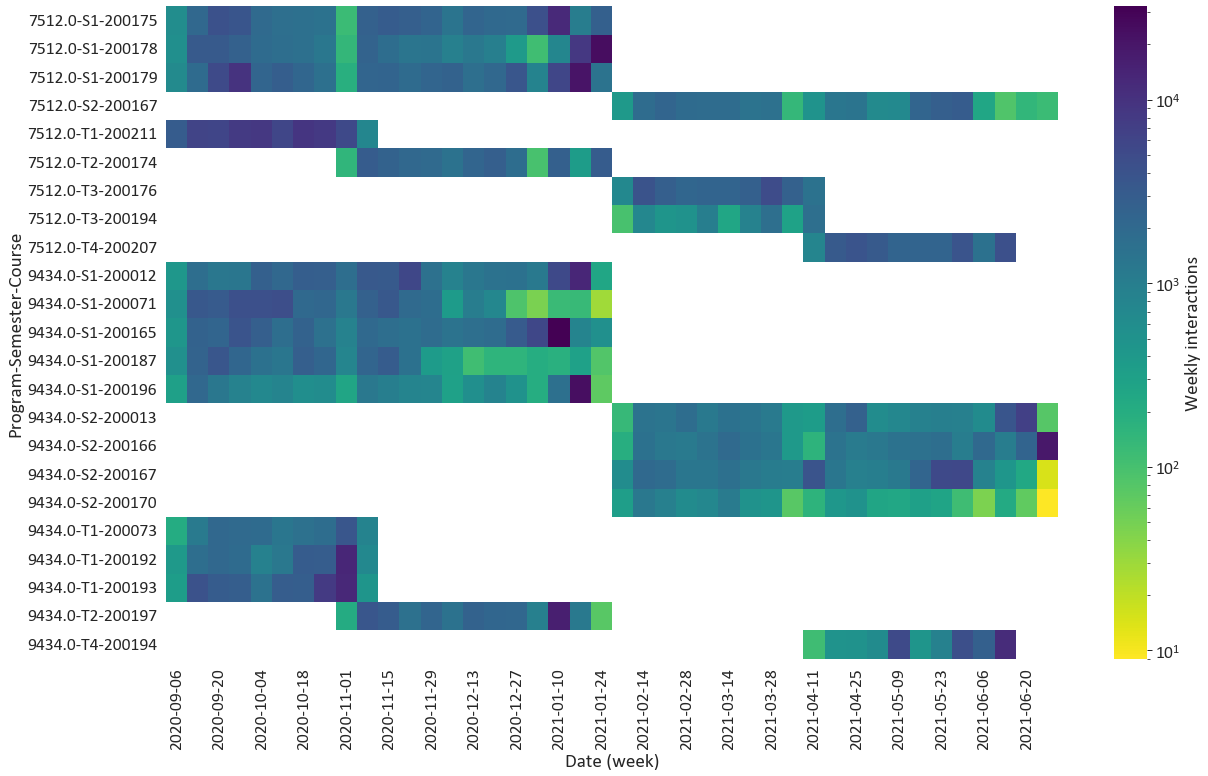

In [19]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the nex
heat4 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= 1,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat4.get_figure()
fig.savefig('../Images/Nova_IMS_highest_attendance_weekly_clicks_heat.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat4

After consideration, we find that the student interactions seem to be consistent with the course duration. 

**1. First, we filter by our current list of valid courses.**

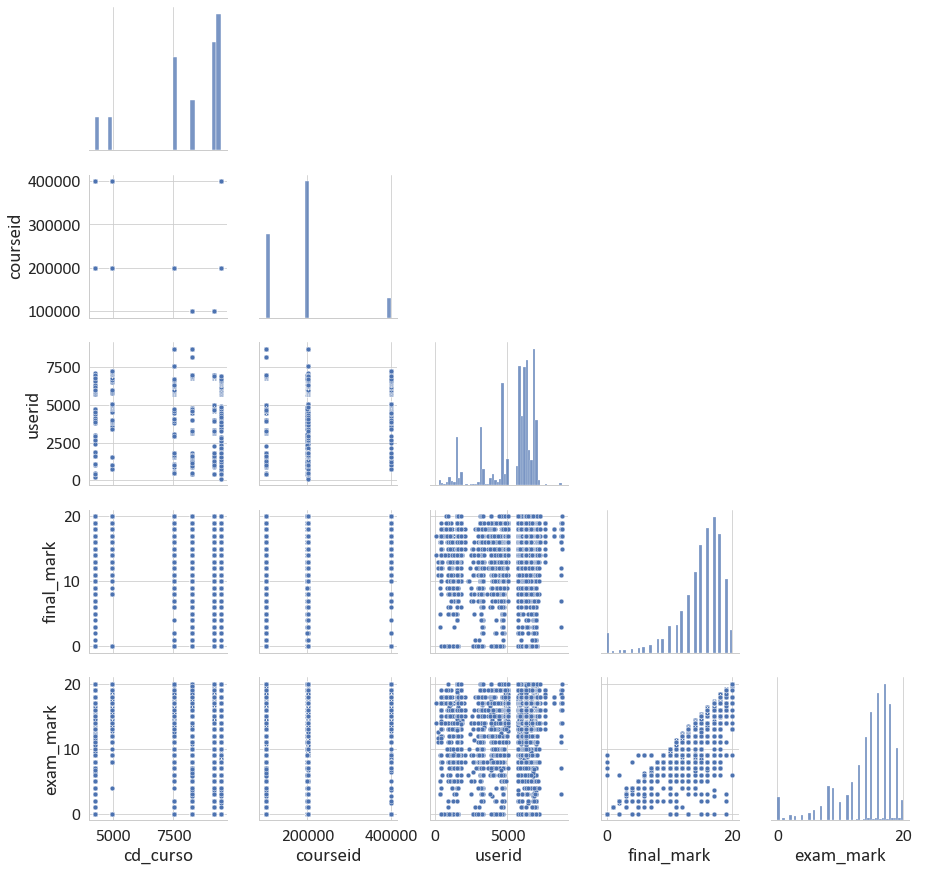

In [20]:
#Representation of different targets depending 
g = sns.PairGrid(targets_table, diag_sharey=False, corner=True)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()

In [21]:
#a larger overlook at the different courses
targets_table.groupby(['cd_curso', 'semestre', 'courseid']).agg({
                                    'userid' : 'count', 
                                    'exam_mark' : ['min', 'mean', 'max'],                                    
                                    'final_mark' : ['min', 'mean', 'max'],
                                    }).describe(include = 'all')

userid   exam_mark                          final_mark              \
            count         min        mean         max         min        mean   
count  134.000000  134.000000  134.000000  134.000000  134.000000  134.000000   
mean    68.074627    5.187313   13.855258   18.318582    5.447761   14.279519   
std     45.718923    5.134366    2.715552    2.188468    5.227986    2.575917   
min      1.000000    0.000000    1.000000    2.000000    0.000000    1.000000   
25%     35.250000    0.000000   12.506720   18.000000    0.000000   13.308340   
50%     68.000000    3.000000   14.299484   19.000000    4.000000   14.627048   
75%     89.750000    9.000000   15.875818   20.000000    9.750000   16.179851   
max    179.000000   17.000000   17.840580   20.000000   17.000000   17.904762   

                   
              max  
count  134.000000  
mean    18.395522  
std      2.173036  
min      2.000000  
25%     18.000000  
50%     19.000000  
75%     20.000000  
max     20.000000

**We will finish by taking a look at our support table**. This table associates all students attending a specific course and the partial grades obtained by each student.

In the Nova IMS these grades are not timestamped (i.e. we do not know to which assignment-quizz-event the partial grade refers to nor when the specific assignment refers to).

In [22]:
#get info
support_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26511 entries, 0 to 26510
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   cd_curso         26511 non-null  object        
 1   semestre         26511 non-null  object        
 2   courseid         26511 non-null  object        
 3   statusAvaliacao  25486 non-null  object        
 4   userid           26511 non-null  object        
 5   assignment_mark  25486 non-null  float64       
 6   assign_id        25486 non-null  object        
 7   nm_curso_pt      26511 non-null  object        
 8   ds_discip_pt     26511 non-null  object        
 9   end_date         26511 non-null  datetime64[ns]
 10  startdate        26511 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(8)
memory usage: 2.2+ MB


In [23]:
support_table.describe(include = 'all', datetime_is_numeric = True)

,cd_curso,semestre,courseid,statusAvaliacao,userid,assignment_mark,assign_id,nm_curso_pt,ds_discip_pt,end_date,startdate
count,26511.0,26511,26511.0,25486,26511.0,25486.000000,25486.0,26511,26511,26511,26511
unique,6.0,6,83.0,11,1349.0,NaN,454.0,6,79,NaN,NaN
top,9155.0,S1,200071.0,Nota Parcial 1,4675.0,NaN,1551.0,Licenciatura em Gestão de Informação,Gestão do Conhecimento,NaN,NaN
freq,7572.0,11353,1036.0,7604,54.0,NaN,179.0,7572,1036,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,14.248799,NaN,NaN,NaN,2021-03-26 19:45:08.656784128,2020-11-24 06:20:52.280185856
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,2020-11-06 00:00:00,2020-09-07 00:00:00
25%,NaN,NaN,NaN,NaN,NaN,12.100000,NaN,NaN,NaN,2021-01-22 00:00:00,2020-09-07 00:00:00
50%,NaN,NaN,NaN,NaN,NaN,15.700000,NaN,NaN,NaN,2021-01-22 00:00:00,2020-11-02 00:00:00
75%,NaN,NaN,NaN,NaN,NaN,17.637500,NaN,NaN,NaN,2021-06-25 00:00:00,2021-02-08 00:00:00
max,NaN,NaN,NaN,NaN,NaN,20.000000,NaN,NaN,NaN,2021-06-25 00:00:00,2021-04-12 00:00:00


In [24]:
support_table

,cd_curso,semestre,courseid,statusAvaliacao,userid,assignment_mark,assign_id,nm_curso_pt,ds_discip_pt,end_date,startdate
0,8259.0,S1,100001.0,NaN,1544.0,NaN,NaN,Licenciatura em Sistemas e Tecnologias de Info...,Álgebra Linear,2021-01-22,2020-09-07
1,8259.0,S1,100001.0,Nota Parcial 1,1556.0,13.90,0.0,Licenciatura em Sistemas e Tecnologias de Info...,Álgebra Linear,2021-01-22,2020-09-07
2,8259.0,S1,100001.0,Nota Parcial 2,1556.0,8.70,1.0,Licenciatura em Sistemas e Tecnologias de Info...,Álgebra Linear,2021-01-22,2020-09-07
3,9155.0,S1,100001.0,Nota Parcial 1,1564.0,16.80,2.0,Licenciatura em Gestão de Informação,Álgebra Linear,2021-01-22,2020-09-07
4,9155.0,S1,100001.0,Nota Parcial 2,1564.0,7.30,3.0,Licenciatura em Gestão de Informação,Álgebra Linear,2021-01-22,2020-09-07
...,...,...,...,...,...,...,...,...,...,...,...
26506,7512.0,T4,200207.0,Nota Parcial 5,7590.0,17.45,1767.0,Mestrado em Métodos Analíticos Avançados,Modelação e Gestão de Big Data,2021-06-11,2021-04-12
26507,7512.0,T4,200207.0,Nota Parcial 1,8735.0,17.00,1764.0,Mestrado em Métodos Analíticos Avançados,Modelação e Gestão de Big Data,2021-06-11,2021-04-12
26508,7512.0,T4,200207.0,Nota Parcial 2,8735.0,20.00,1765.0,Mestrado em Métodos Analíticos Avançados,Modelação e Gestão de Big Data,2021-06-11,2021-04-12
26509,7512.0,T4,200207.0,Nota Parcial 4,8735.0,17.20,1766.0,Mestrado em Métodos Analíticos Avançados,Modelação e Gestão de Big Data,2021-06-11,2021-04-12


In [25]:
#a larger overlook at the different courses
support_table.groupby(['cd_curso', 'semestre', 'courseid']).agg({
                                    'userid' : 'nunique',
                                    'assign_id' : 'nunique', 
#                                     'mandatory_status' : 'mean',
#                                     'delivered' : 'mean',                                    
                                    'assignment_mark' : 'mean',
                                    }).describe(include = 'all')

,userid,assign_id,assignment_mark
count,134.000000,134.000000,120.000000
mean,68.074627,3.388060,13.853891
std,45.718923,1.930797,2.695695
min,1.000000,0.000000,1.750000
25%,35.250000,2.000000,12.923040
50%,68.000000,3.000000,14.320545
75%,89.750000,4.000000,15.735984
max,179.000000,11.000000,19.000000


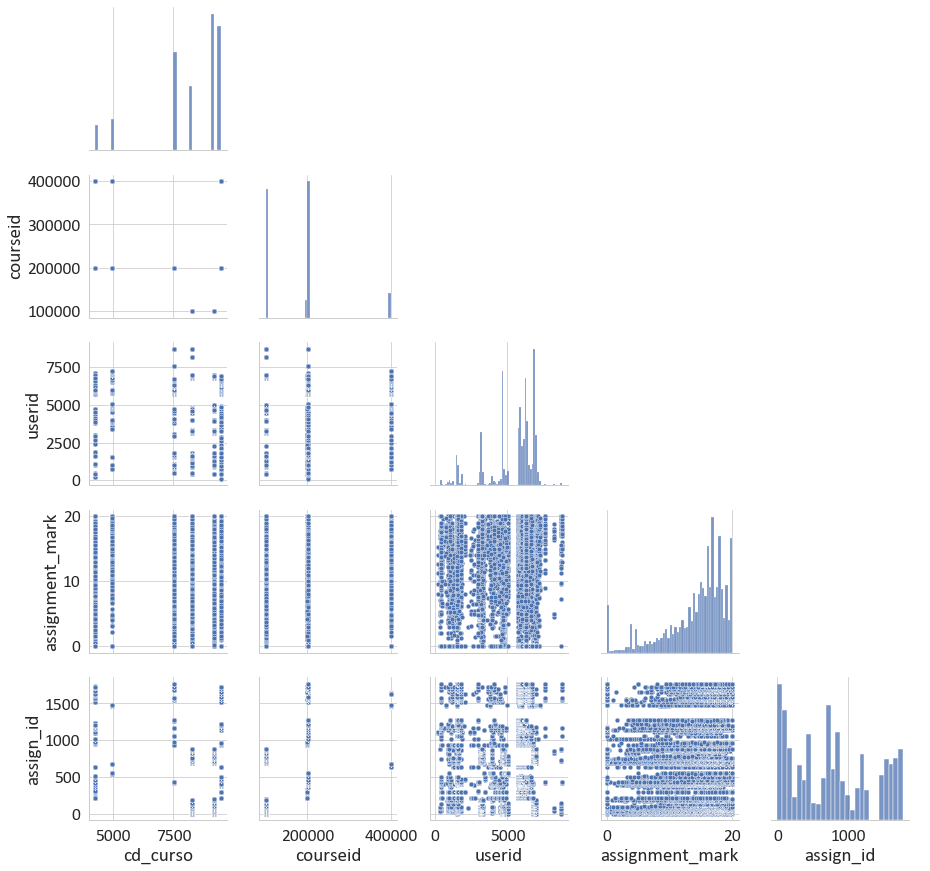

In [26]:
#Representation of different targets depending 
g = sns.PairGrid(support_table, diag_sharey=False, corner=True)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()

**Going forward**.

After this preliminary look, we will go forward with extracting features from the Moodle logs. 

In this notebook, we will consider a static non-temporal representation that considers each student-course pair as a row. We will, however, construct different datasets - 1 for each relevant timestep. 

We will rely on features that are regular presences in the literature. Some of these features may appear in more than one work:

**From Macfadyen et al. (2010)**

Count related features:
- Discussion messages posted, 
- Online Sessions, 
- File views,
- Assessments finished, 
- Assessments started, 
- Replies to discussion messages, 
- Mail messages sent, 
- Assignments submitted, 
- Discussion MEssages read, 
- Web link views

Time related features:
- Total time online, 
- Time spent on assignments,


**From Romero et al. (2013)**

Number Accesses to:
- Assignments done,
- Quizzes passed,
- Quizzes failed,
- Forum messages posted, 
- Forum messages read,

Time related features:
- Total time on assignments, 
- Total time on quizzes, 
- Total time on forums

**From Gasevic et. al (2016)**

Number of Accesses of the following variables:
- course logins,
- forum,
- resources,
- Turnitin file submission,
- assignments,
- book,
- quizzes, 
- feedback,
- lessons,
- virtual classroom
- chat,

- etc...

**From Conijn et. al (2017)**

Click count related features:
- Clicks,
- Online sessions, 
- Course page views,
- Resources viewed,
- Links viewed, 
- Discussion post views,
- Content page views,
- Quizzes,
- Quizzes passed,
- Assignments submitted, 
- Wiki edits,
- Wiki views,

Time related features:
- Total time online,
- Largest period of inactivity,
- Time until first action, 
- Averages session time,

Performance related features:
- Average assignment grade,

**Chen and Cui (2020)**

Click count related features:
- Total clicks, 
- Clicks on campus, 
- Online sessions,
- Clicks during weekdays,
- Clicks on weekend,
- Assignments, 
- File,
- Forum,
- Overview Report,
- Quizz,
- System, 
- User Report

Time related features
- Total time of online sessions, 
- Mean duration of online sessions, 
- SD of time between sessions, 
- Total time on Quiz, 
- Total time on File, 
- SD of time on File, 

Other statistics
- Ratio between on-campups and off-campus clicks

**Nuno Rosário Thesis**
- number of forum messages read, 
- number of forum messages posted, 
- number of pages,
- number of clicks, 
- number of submissions,
- number of files accessed,

As stated, some of the features are calculated across multiple works - and these only address the course level. They are not designed specifically for course-agnostic purposes.

**We will split the logs by the difference courses and, for each student calculate the different features we intend to calculate.** The are calculated via aggregate operations, from the most common (appear more times in our literature).

**But before that**, we will look at different columns of our logs and, when appropriate, keep the different values they may take. We can look at the actions, the objecttables and the component.

For each of the relevant columns: objecttable, target, component and action we will look to make adjustments to multiple categories.

In [27]:
#correct objecttable
other_objects =  ['tag_instance', 'badge', 'feedback_completed', 'feedback', 'course_modules_completion', 'feedback']

#badges on target id
badges_on_target = ['badge_listing', 'badge', 'recent_activity']

#grades 
grading_objects = ['gradereport_overview', 'gradereport_user']

#assignment from elements in the component column
assign_objects = ['assignsubmission_onlinetext', 'assignsubmission_comments', 'mod_assign', 'assignsubmission_file']

#workshop
workshops = ['workshop_submissions', 'workshop']

#course
courses_on_target = ['course', 'course_resources_list', 'course_user_report', 'page']

#corrections on the objecttable column
student_logs['objecttable'] = np.where(student_logs['objecttable'].isin(other_objects),
                                      'other',
                                       np.where(student_logs['target'].isin(badges_on_target),
                                      'other',
                                       np.where(student_logs['target'].isin(courses_on_target),
                                      'course',
                                      np.where(student_logs['component'] == 'mod_forum',
                                      'forum',
                                      np.where(student_logs['component'].isin(grading_objects),
                                      'grade_grades',
                                       np.where(student_logs['component'].isin(assign_objects),
                                      'assignments',
                                       np.where(student_logs['objecttable'].isin(workshops),
                                      'workshop', 
                                       np.where(student_logs['objecttable'] == 'book_chapters',
                                      'book',
                                       np.where(student_logs['component'] == 'mod_coice',
                                      'choice',
                                       np.where(student_logs['component'] == 'mod_choicegroup',
                                      'groups',
                                      np.where((student_logs['component'] == 'mod_quiz') & (student_logs['objecttable'].isna()),'quiz',
                                      student_logs['objecttable'])))))))))))

del other_objects, badges_on_target, grading_objects, assign_objects, workshops, courses_on_target

In [28]:
# #uncomment to verify pairings
# with pd.option_context('display.max_rows', None,):
#      display(student_logs['objecttable'].value_counts())

In [29]:
# #uncomment to verify pairings
# with pd.option_context('display.max_rows', None,):
#      display(student_logs['component'].value_counts())

In [30]:
# #uncomment to verify pairings
# with pd.option_context('display.max_rows', None,):
#      display(student_logs['target'].value_counts())

In [31]:
# #uncomment to verify pairings
# with pd.option_context('display.max_rows', None,):
#      display(student_logs['action'].value_counts())

Likewise, we will need to take a look at the different actions in order to understand how common these may be. 

Again, we will look at different actions and see how we can group them together in a way that, at least, makes intuitive sense. There is use in keeping the distinction between different types of view.

In [32]:
#updates and edits related to making editions on presented information:

#additions 
addition = ['created', 'added']

#deletion
deletion = ['deleted', 'removed']

#other actions
other_actions = ['awarded', 'printed', 'abandoned', 'searched']

#submissions
submission = ['submitted', 'submission', 'submissions']

#converts discussion points to forum or, alternatively,groups other elements to other category
student_logs['action'] = np.where(student_logs['action'].isin(addition), 'added', #addition list
                                  np.where(student_logs['action'].isin(deletion), 'delete', #deletion list
                                  np.where(student_logs['action'].isin(other_actions), 'other actions', #other actions
                                  np.where(student_logs['action'].isin(submission), 'submission', #submissions to submission
                                  student_logs['action']
                                 ))))

#we finish by ending these lists we've created
del addition, deletion, other_actions, submission

In [33]:
# #uncomment to verify pairings
with pd.option_context('display.max_rows', None,):
     display(student_logs.groupby(['objecttable', 'target', 'action']).size().to_frame())

0
objecttable     target                       action               
assignments     assessable                   submission       6695
                                             uploaded         6742
                comment                      added             156
                                             delete             10
                course_module_instance_list  viewed             11
                statement                    accepted          112
                submission                   added            5634
                                             updated          1108
                submission_confirmation_form viewed             98
                submission_form              viewed          11562
                submission_status            viewed          38302
book            chapter                      other actions       1
                                             viewed              8
                course_module                viewed            362
choice          course_module                viewed           5849
choice_answers  answer                       added            1487
                                             delete             60
course          course                       other actions      42
                                             viewed         923752
                course_resources_list        viewed             36
                course_user_report           viewed            694
                user_list                    viewed          10083
folder          all_files                    downloaded      12050
                course_module                viewed         101106
forum           assessable                   uploaded          889
                course_module                viewed          51817
                course_module_instance_list  viewed            123
                discussion                   added             117
                                             delete              7
                                             viewed          46474
                discussion_subscription      added             446
                                             delete             75
                post                         added             572
                                             delete             40
                                             updated           200
                subscription                 added              17
                                             delete              2
                user_report                  viewed             51
grade_grades    grade_report                 viewed           9992
                user                         graded           8211
groups          choice                       delete            206
                                             updated          3586
                course_module                viewed          22915
                group_member                 added            3591
                                             delete            208
other           badge                        other actions      94
                                             updated             1
                badge_listing                viewed            824
                course_module                viewed            825
                course_module_completion     updated          1381
                recent_activity              viewed             29
                response                     submission        208
                tag                          added               1
page            course_module                viewed          25129
quiz            course_module                viewed          66861
                course_module_instance_list  viewed            151
quiz_attempts   attempt                      becameoverdue     258
                                             other actions      13
                                             

We do not know, yet, whether we can make an effective association between the partial grades and the logs. We can explore the submissions made in each discipline and calculate the likely dates of submission.

For that, for every course, we will look at submissions performed by the different students.

We will count the number of assignments assigned to each discipline - the number of graded assignments givenaverage number of grades attributed in each curricular unit.

In [34]:
#then we get all unique entries and assign them an index number
courses = class_list[['cd_curso', 'semestre', 'courseid']].drop_duplicates().reset_index(drop = True).reset_index()

#then, we create a dict using the combination of index, courseid and status as keys
courses = courses.set_index(['cd_curso', 'semestre', 'courseid']).to_dict()['index']

#set index of df to match same index
class_list.set_index(['cd_curso', 'semestre', 'courseid'], drop = True, inplace = True)

#set index of df to match same index
student_logs.set_index(['cd_curso', 'semestre', 'courseid'], drop = True, inplace = True)

#set index of support_df to match same index
support_table.set_index(['cd_curso', 'semestre', 'courseid'], drop = True, inplace = True)

#set index of targets_table to match same index
targets_table.set_index(['cd_curso', 'semestre', 'courseid'], drop = True, inplace = True)

#use index as key for dict
student_logs['course_encoding'] = student_logs.index.map(courses).astype(object)
class_list['course_encoding'] = class_list.index.map(courses).astype(object)
support_table['course_encoding'] = support_table.index.map(courses).astype(object)
targets_table['course_encoding'] = targets_table.index.map(courses).astype(object)

#resetting index
student_logs = student_logs.dropna(subset = ['course_encoding']).reset_index()
class_list.reset_index(inplace = True)
support_table = support_table.dropna(subset = ['course_encoding']).reset_index()
targets_table = targets_table.dropna(subset = ['course_encoding']).reset_index()

In [35]:
#first, get count of assignments as defined in the support_table 
assignments_per_course = support_table.groupby('course_encoding').agg({'assign_id' : 'nunique'})
assignments_per_course = assignments_per_course.to_dict()['assign_id']

#next, we filter by only keepting submissions, avoid the first 2 weeks of submissions
submission_logs = student_logs[(student_logs['action'] == 'submission') & (student_logs['time'] >= '2020-09-18')].sort_values(by = 'time').reset_index(drop = True)

In [36]:
support_table

,cd_curso,semestre,courseid,statusAvaliacao,userid,assignment_mark,assign_id,nm_curso_pt,ds_discip_pt,end_date,startdate,course_encoding
0,8259.0,S1,100001.0,NaN,1544.0,NaN,NaN,Licenciatura em Sistemas e Tecnologias de Info...,Álgebra Linear,2021-01-22,2020-09-07,30.0
1,8259.0,S1,100001.0,Nota Parcial 1,1556.0,13.90,0.0,Licenciatura em Sistemas e Tecnologias de Info...,Álgebra Linear,2021-01-22,2020-09-07,30.0
2,8259.0,S1,100001.0,Nota Parcial 2,1556.0,8.70,1.0,Licenciatura em Sistemas e Tecnologias de Info...,Álgebra Linear,2021-01-22,2020-09-07,30.0
3,9155.0,S1,100001.0,Nota Parcial 1,1564.0,16.80,2.0,Licenciatura em Gestão de Informação,Álgebra Linear,2021-01-22,2020-09-07,41.0
4,9155.0,S1,100001.0,Nota Parcial 2,1564.0,7.30,3.0,Licenciatura em Gestão de Informação,Álgebra Linear,2021-01-22,2020-09-07,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...
24379,7512.0,T4,200207.0,Nota Parcial 5,7590.0,17.45,1767.0,Mestrado em Métodos Analíticos Avançados,Modelação e Gestão de Big Data,2021-06-11,2021-04-12,29.0
24380,7512.0,T4,200207.0,Nota Parcial 1,8735.0,17.00,1764.0,Mestrado em Métodos Analíticos Avançados,Modelação e Gestão de Big Data,2021-06-11,2021-04-12,29.0
24381,7512.0,T4,200207.0,Nota Parcial 2,8735.0,20.00,1765.0,Mestrado em Métodos Analíticos Avançados,Modelação e Gestão de Big Data,2021-06-11,2021-04-12,29.0
24382,7512.0,T4,200207.0,Nota Parcial 4,8735.0,17.20,1766.0,Mestrado em Métodos Analíticos Avançados,Modelação e Gestão de Big Data,2021-06-11,2021-04-12,29.0


In [37]:
#second filtering condition - keep add, assessable and attempts -> edits and deletes are not relevant to determine number of submissions
submission_logs = submission_logs[submission_logs['target'].isin(target_to_keep := ['add',
                                                                                    'assessable',
                                                                                    'attempt',
                                                                                   ])]
#add number of assignments of submission_logs
submission_logs['nbr_assignments'] = submission_logs['course_encoding'].map(assignments_per_course)

#we give each submission made by each student in the context of certain curricular units
submission_logs['course_student_submission_number'] = submission_logs.groupby(['course_encoding', 'userid']).cumcount() + 1
submission_logs = submission_logs.filter(['course_encoding', 'userid', 'time', 'course_student_submission_number', 'nbr_assignments'])

#then, we get the number of submissions made by each student and the average date for each submission
submission_logs = submission_logs.groupby(['course_encoding', 'course_student_submission_number']).agg(
                                                                                {
                                                                                    'userid': 'count',
                                                                                    'time': ['mean', 'median'],
                                                                                    'nbr_assignments': 'mean' #equal to same 
                                                                                })

#applies the function that removes multiindex
submission_logs.columns = submission_logs.columns.map(flattenHierarchicalCol)
submission_logs.reset_index(inplace = True)

#then, we only keep the number of submissions that is in line with the number on the support_table
submission_logs = submission_logs[submission_logs['course_student_submission_number'] <= submission_logs['nbr_assignments_mean']].reset_index(drop = True)
submission_logs['course_student_submission_number'] = submission_logs['course_student_submission_number'].astype(object)
submission_logs['course_encoding'] = submission_logs['course_encoding'].astype(object)

#then, in order to make the proper merge, we'll need to make the proper adjustments - namely label the submission date of each discipline
support_table['course_student_submission_number'] = pd.to_numeric(support_table['statusAvaliacao'].str.extract('(\d+)', expand=False)).astype(object)

In this next step we, we will timestamp each assignment recorded on the support table. It is likely that, in group assigments, only one student submits for all coleagues. Therefore, it is not possible to make a 1 to 1 between submission and grade.

In general -> Partial grade 1 refers to a student's first submission, partial grade 2 to the second submission, etc...
We will assume deadline date for each partial grade to be the median delivery date of the classe's ith submission.

In [38]:
#filtering columns before merge
submission_logs = submission_logs.filter(['course_encoding', 'course_student_submission_number',
                                         'time_median'])

#making a rightward merge with the support_table on course_encoding and course_student_submission_number
support_table = pd.merge(support_table, submission_logs, on = ['course_encoding', 'course_student_submission_number'], how = 'left')

#at this stage, we can now start dropping columns that are ultimately unnecessary and reclaibrating the assign_id column
support_table['assign_id'] = support_table.groupby(['course_encoding', 'statusAvaliacao']).ngroup()
support_table['sup_time'] = pd.to_datetime(support_table['time_median'].dt.date)
support_table.drop(['statusAvaliacao', 'course_student_submission_number', 'time_median'], axis = 1, inplace = True)

del submission_logs, assignments_per_course

In [39]:
support_table.describe(include = 'all', datetime_is_numeric = True)

,cd_curso,semestre,courseid,userid,assignment_mark,assign_id,nm_curso_pt,ds_discip_pt,end_date,startdate,course_encoding,sup_time
count,24384.000000,24384,24384.000000,24384.0,23442.000000,24384.000000,24384,24384,24384,24384,24384.0,18030
unique,NaN,6,NaN,1258.0,NaN,NaN,6,79,NaN,NaN,92.0,NaN
top,NaN,S1,NaN,4747.0,NaN,NaN,Licenciatura em Gestão de Informação,Gestão do Conhecimento,NaN,NaN,70.0,NaN
freq,NaN,10401,NaN,53.0,NaN,NaN,7344,1017,NaN,NaN,1017.0,NaN
mean,8335.224615,NaN,177313.268496,NaN,14.421897,150.781250,NaN,NaN,2021-03-25 11:58:13.700787456,2020-11-23 22:32:35.905511936,NaN,2021-03-03 04:29:33.044925184
min,4281.000000,NaN,100001.000000,NaN,0.000000,-1.000000,NaN,NaN,2020-11-06 00:00:00,2020-09-07 00:00:00,NaN,2020-09-22 00:00:00
25%,7512.000000,NaN,100073.000000,NaN,12.500000,64.000000,NaN,NaN,2021-01-22 00:00:00,2020-09-07 00:00:00,NaN,2021-01-01 00:00:00
50%,9155.000000,NaN,200071.000000,NaN,15.800000,149.000000,NaN,NaN,2021-01-22 00:00:00,2020-11-02 00:00:00,NaN,2021-03-23 00:00:00
75%,9434.000000,NaN,200192.000000,NaN,17.750000,246.000000,NaN,NaN,2021-06-25 00:00:00,2021-02-08 00:00:00,NaN,2021-05-29 00:00:00
max,9434.000000,NaN,400090.000000,NaN,20.000000,312.000000,NaN,NaN,2021-06-25 00:00:00,2021-04-12 00:00:00,NaN,2021-06-24 00:00:00


In [40]:
support_table.head()

,cd_curso,semestre,courseid,userid,assignment_mark,assign_id,nm_curso_pt,ds_discip_pt,end_date,startdate,course_encoding,sup_time
0,8259.0,S1,100001.0,1544.0,NaN,-1,Licenciatura em Sistemas e Tecnologias de Info...,Álgebra Linear,2021-01-22,2020-09-07,30.0,NaT
1,8259.0,S1,100001.0,1556.0,13.9,85,Licenciatura em Sistemas e Tecnologias de Info...,Álgebra Linear,2021-01-22,2020-09-07,30.0,NaT
2,8259.0,S1,100001.0,1556.0,8.7,86,Licenciatura em Sistemas e Tecnologias de Info...,Álgebra Linear,2021-01-22,2020-09-07,30.0,NaT
3,9155.0,S1,100001.0,1564.0,16.8,130,Licenciatura em Gestão de Informação,Álgebra Linear,2021-01-22,2020-09-07,41.0,NaT
4,9155.0,S1,100001.0,1564.0,7.3,131,Licenciatura em Gestão de Informação,Álgebra Linear,2021-01-22,2020-09-07,41.0,NaT


We have addressed the most obvious possible aggregations. Now, we will go forward with our intended feature extraction and selection.

We can start by removing all of the unnecessary columns that we will not be using going forward and, then, create 5 distinct dicts of dataframes. Each dict refers to a certain course duration threshold.

In [41]:
#filtering for 
student_logs = student_logs.filter(['cd_curso', 'semestre', 'courseid', 'objecttable', 'action', 'target', 'component',
                                   'userid', 'time', 'course_encoding'])

In [42]:
#number of days
days = {}

#additionally, we will look at our estimated course duration
for i in tqdm(duration_threshold):
    #create, for each desired threshold, the appropriate cutoff date 
    class_list[f'Date_threshold_{int(i*100)}'] = pd.to_datetime((class_list['Start Date'] + pd.to_timedelta(class_list['Course duration days'] * i, unit = 'Days')).dt.date)
    
        #setting up duration threshold to be on friday -> reason being that it will be easier to 
    class_list[f'Date_threshold_{int(i*100)}'] = class_list[f'Date_threshold_{int(i*100)}'].where( class_list[f'Date_threshold_{int(i*100)}'] == (( class_list[f'Date_threshold_{int(i*100)}'] + Week(weekday=4)) - Week()), class_list[f'Date_threshold_{int(i*100)}'] + Week(weekday=4))

        #storing date threshold and week, week before start to consider calculate features relative to course duration
    days[f'Date_threshold_{int(i*100)}'] = deepcopy(class_list.filter(['course_encoding', 'Start Date', 'Week before start', 'End Date',
                                                                                                      f'Date_threshold_{int(i*100)}']))
    
    days[f'Date_threshold_{int(i*100)}']['Number of days'] = (days[f'Date_threshold_{int(i*100)}'][f'Date_threshold_{int(i*100)}'] - days[f'Date_threshold_{int(i*100)}'][f'Week before start']).dt.days

#then, we will create a dictionary of dictionaries, each main dictionary storing and a version of the logs 
logs_dict = {}
assignment_dict = {}

for i in tqdm(duration_threshold):
    #create, for each desired threshold, a different dictionary of dataframes wherein we will perform the different operations
    print(f'Date_threshold_{int(i*100)}\n' +
          f'Logs')
    logs_dict[f'Date_threshold_{int(i*100)}'] = {course: student_logs.loc[student_logs['course_encoding'] == course].reset_index(drop = True) for course in tqdm(student_logs['course_encoding'].unique())}
    
    #Assignments
    print(f'Assignments')
    assignment_dict[f'Date_threshold_{int(i*100)}'] = {course: support_table.loc[support_table['course_encoding'] == course].reset_index(drop = True) for course in tqdm(support_table['course_encoding'].unique())}

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Date_threshold_10
Logs


  0%|          | 0/92 [00:00<?, ?it/s]

Assignments


  0%|          | 0/92 [00:00<?, ?it/s]

Date_threshold_25
Logs


  0%|          | 0/92 [00:00<?, ?it/s]

Assignments


  0%|          | 0/92 [00:00<?, ?it/s]

Date_threshold_33
Logs


  0%|          | 0/92 [00:00<?, ?it/s]

Assignments


  0%|          | 0/92 [00:00<?, ?it/s]

Date_threshold_50
Logs


  0%|          | 0/92 [00:00<?, ?it/s]

Assignments


  0%|          | 0/92 [00:00<?, ?it/s]

Date_threshold_100
Logs


  0%|          | 0/92 [00:00<?, ?it/s]

Assignments


  0%|          | 0/92 [00:00<?, ?it/s]

In [43]:
days['Date_threshold_10']

,course_encoding,Start Date,Week before start,End Date,Date_threshold_10,Number of days
0,0,2020-09-07,2020-08-31,2021-01-22,2020-09-25,25
1,1,2020-09-07,2020-08-31,2021-01-22,2020-09-25,25
2,2,2020-09-07,2020-08-31,2021-01-22,2020-09-25,25
3,3,2021-02-08,2021-02-01,2021-06-25,2021-02-26,25
4,4,2021-02-08,2021-02-01,2021-06-25,2021-02-26,25
...,...,...,...,...,...,...
87,87,2020-11-02,2020-10-26,2021-01-22,2020-11-13,18
88,88,2020-11-02,2020-10-26,2021-01-22,2020-11-13,18
89,89,2021-02-08,2021-02-01,2021-04-09,2021-02-19,18
90,90,2021-02-08,2021-02-01,2021-04-09,2021-02-19,18


Now, we have a nested dictionary with different dataframes inside it. We will use this data structure to perform the most of the operations we are interested in.

**First, we will add, to each dataframe, a column with the corresponding threshold date**

After this cleaning procedure, we will all different columns referring to our features of interest. These will be:
1. Number of assignments submitted, 
2. Number of online sessions,
3. Discussion messages read,
4. Resource views, 
5. Assessments started,
6. Total time online,
7. Assignment views,
8. Average duration of session,
9. Messages posted,
10. Clicks on Forum,  
11. Total number if clicks
12. URL Links Viewed
13. Largest period of inactivity
14. Average clicks per day
15. Average clicks per session
16. The start date of the first 10 sessions
17. % of Submissions made in the period,
18. % of clicks made in the period,

To check difference between inclusion and not inclusion

19. Average grade of assignments (optional)

A double loop is not very efficient but, to the best of my ability, is the obvious solution to perform these operations. 

In [44]:
#for each intended course duration threshold
for i in tqdm(logs_dict):
    #start with creating a dictionary of course and intended cuttoff date
    cut = class_list.set_index('course_encoding').to_dict()[i] 
    
    #for each dataframe
    for j in tqdm(logs_dict[i]):
        #where the course is the same as in the class_list, get the corresponding value of the appropriate column,
        logs_dict[i][j]['Date Threshold'] = logs_dict[i][j]['course_encoding'].map(cut)
        logs_dict[i][j] = logs_dict[i][j][logs_dict[i][j]['time'] <= logs_dict[i][j]['Date Threshold']].reset_index(drop = True).drop('Date Threshold', axis = 1)
        
        #doing the same for the assignments list
        try:
            assignment_dict[i][j]['Date Threshold'] = assignment_dict[i][j]['course_encoding'].map(cut)
            assignment_dict[i][j] = assignment_dict[i][j][assignment_dict[i][j]['sup_time'] <= assignment_dict[i][j]['Date Threshold']].reset_index(drop = True).drop('Date Threshold', axis = 1)
        
        except:
            continue

        #calculates the difference between previous within group row and current
        logs_dict[i][j]['t_diff'] = logs_dict[i][j].sort_values(['userid', 'time']).groupby('userid')['time'].diff()
        
        #will need to ignore dictionaries where there is no lenght
        if len(logs_dict[i][j]) > 0:
            #the nans will be correspond to the first interaction made by each student - also signaling the start of the first session
            logs_dict[i][j]['session'] = np.where(logs_dict[i][j]['t_diff'].isna(), 1, #the first session is started by nans
                                             np.where(logs_dict[i][j]['t_diff'] > pd.to_timedelta(40, unit = 'minutes'), 1, #also identify the starting point of new sessions
                                                      0))
            
            #then, we cumulative sum all in-group members 
            logs_dict[i][j]['session'] = logs_dict[i][j].groupby('userid')['session'].transform(pd.Series.cumsum)
            
            #before finishing this step, we will calculate the accumulated duration of a session
            logs_dict[i][j]['mask'] = np.where(logs_dict[i][j]['t_diff'].isna(), 0, #the first session is started by nans
                                      np.where(logs_dict[i][j]['t_diff'] > pd.to_timedelta(40, unit = 'minutes'), 0, #also identify the starting point of new sessions
                                      logs_dict[i][j]['t_diff'].dt.total_seconds()))
            #fillnas in t_diff
            logs_dict[i][j]['t_diff'].fillna(pd.to_timedelta(0), inplace = True)

            #then, we cumulative sum all in-group members 
            logs_dict[i][j]['session_cumul_time'] = logs_dict[i][j].groupby(['userid','session'])['mask'].transform(pd.Series.cumsum)
            logs_dict[i][j]['session_cumul_time'] = pd.to_timedelta(logs_dict[i][j]['session_cumul_time'], unit = 'seconds')
            #drop mask
            logs_dict[i][j].drop('mask', axis = 1, inplace = True)
        
        else:
            logs_dict[i][j] = pd.DataFrame(columns=['cd_curso', 'semestre', 'courseid', 'course_encoding', 'userid', 'time', 'objecttable',
                                                    'action', 'target', 'component', 't_diff', 'session', 'session_cumul_time'])
            continue                                   

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

In [45]:
#create backup of logs dict, we will need it for later
backup = deepcopy(logs_dict)

In [46]:
#create backup of logs dict, we will need it for later
logs_dict = deepcopy(backup)

Now, we'll go forward with the creation of the features using these datasets. We will do it, using groupby commands.

After this cleaning procedure, we will all different columns referring to our features of interest.

**We cannot perform all steps at once, unfortunately.** (at least not in a capacity I can manage)

We will need to create multiple dfs to ensure that all features are accounted for:

1. We start with features that relate to raw aggregate counts of clicks and sessions - a general set of features, 
2. We continue by computing features related with time -  total time online and average duration of session,
3. Then, we go into finer grained features using specific pairs of modules and actions.
4. Then, we finish by merging these features with the final mark we have previously calculated and the average grade of assignments delivered up to the threshold date.

In [47]:
#we will need to perform the same double loop we have done before
for i in tqdm(logs_dict):
     
    for j in tqdm(logs_dict[i]):    
        #as it is very difficult to we will need to create multiple placeholders
        #placeholder 1 - general features
        general_features = logs_dict[i][j].groupby(['course_encoding', 'cd_curso', 'semestre', 'courseid', 'userid']).agg(
                                                {'action' : [('N_clicks','count')], #number of clicks
                                                'session' : [('N_sessions', 'nunique')],
                                                 't_diff' : [('Largest_period_of Inactivity' , 'max')],
                                                 #number of sessions
                                                 })
        
        #the second group will deal with session related time features
        session_features = logs_dict[i][j].groupby(['userid', 'session'])['session_cumul_time'].max().to_frame().reset_index() #the accumulated time up to last click of each session identifies the duration 
        
        #now, we get to our intended features
        session_features = session_features.groupby(['userid']).agg(
                                                {'session_cumul_time' : [np.sum, #The total time online is the sum of the time spent in all sessions 
                                                                        np.mean], #mean duration across all sessions made by the student
                                                 })
        
        #start og multiple session
        start_of_sessions = logs_dict[i][j].groupby(['userid', 'session']).agg({
                                                                                'time' : 'min',
                                                                                }).reset_index()
        
        #we will get the start dates of the first 10 sessions
        start_of_sessions = pd.pivot_table(start_of_sessions, index = 'userid', columns = 'session', values = 'time',
                            aggfunc = 'min').reset_index()
        
        # We reindex pivot to contain all columns we intend to have, even if they are note present
        start_of_sessions = start_of_sessions.reindex(columns = ['userid', 1, 2, 3, 4, 5,
                                                                6, 7, 8, 9, 10], fill_value = np.nan).rename(
                                                                    columns = {1 : 'Start of Session 1 (%)', 
                                                                               2 : 'Start of Session 2 (%)',
                                                                               3 : 'Start of Session 3 (%)',
                                                                               4 : 'Start of Session 4 (%)',
                                                                               5 : 'Start of Session 5 (%)',
                                                                               6 : 'Start of Session 6 (%)', 
                                                                               7 : 'Start of Session 7 (%)',
                                                                               8 : 'Start of Session 8 (%)',
                                                                               9 : 'Start of Session 9 (%)',
                                                                               10 : 'Start of Session 10 (%)',
                                                                              })
        
        #the third relies on clicks of multiple types and modules. An elegant way is to deal with these is pivot_tables of the counts
        pivot = pd.pivot_table(logs_dict[i][j], index = 'userid', 
                              columns = ['objecttable', 'target', 'action'],
                              values='component',
                              aggfunc = 'count')
        
        #applies the function that removes multiindex
        pivot.columns = pivot.columns.map(flattenHierarchicalCol)
        pivot.reset_index(inplace = True)
        
        #We want to retain the following columns and create empty versions when the columns are not available
        columns_to_check = [
                               'userid',
                               'assignments_assessable_submission', #Number of assignments submitted
                               'turnitintooltwo_add_submission', # turnitin submissions                              
                               'resource_course_module_viewed', #resource views,
                               'assignments_submission_form_viewed', #view assignment
                               'assignments_submission_status_viewed', #submission status of assignment
                               'forum_discussion_viewed', #view discussion,
                               'quiz_attempts_attempt_started', #quizzes started
                               'forum_discussion_added', #forum discussions posted
                               'forum_post_added', 
                                ]
        
        # We reindex pivot to contain all columns we intend to have, even if they are note present
        pivot = pivot.reindex(columns = columns_to_check)
        
        #adding columns that refer to the same things - asssignments
        pivot['Assignments submitted'] = pivot['assignments_assessable_submission'] + pivot['turnitintooltwo_add_submission']
        
        #assignment views 
        pivot['Assignments viewed'] = pivot['assignments_submission_form_viewed'] + pivot['assignments_submission_status_viewed']
        
        #forum posts - discussions or posts added
        pivot['Forum posts'] = pivot['forum_discussion_added'] + pivot['forum_post_added']
        
        #drop columns unnecessary columns and rename others 
        pivot = pivot.rename(columns = {
                                            'forum_discussion_viewed' : 'Discussions viewed',
                                            'resource_course_module_viewed' : 'Resources viewed',
                                            'quiz_attempts_attempt_started' : 'Quizzes started', 
                                           }).drop(['assignments_assessable_submission',
                                                    'turnitintooltwo_add_submission',
                                                    'assignments_submission_form_viewed',
                                                    'assignments_submission_status_viewed',
                                                    'forum_discussion_added',
                                                    'forum_post_added'], axis = 1)
        
        #the third relies on clicks of multiple types and modules. An elegant way is to deal with these is pivot_tables of the counts
        pivot_1 = pd.pivot_table(logs_dict[i][j], index = 'userid', 
                              columns = 'objecttable',
                              values='component',
                              aggfunc = 'count').reset_index()
        
        #now, we filter the pivot table to only keep the features that we are interested in - specifically, the counts
        pivot_1 = pivot_1.filter([
                               'userid',
                               'forum'
                                'url' #links viewed
                                'folder', #Folders viewed
                                'course',
                                ], 
                               ).rename(columns = {'forum' : 'Clicks on Forum',
                                                   'url' : 'Links viewed',
                                                   'folder' : 'Clicks on folder',
                                                   'course' : 'Clicks on Course',
                                                  })


        #applies the function that removes multiindex
        general_features.columns = general_features.columns.map(flattenHierarchicalCol)
        general_features.reset_index(inplace = True)
        
        #same for session features
        session_features.columns = session_features.columns.map(flattenHierarchicalCol)
        session_features.reset_index(inplace = True)
        
        #merging the timestamp that marks the start of the first 5 sessions
        session_features = pd.merge(session_features, start_of_sessions, on = 'userid')
        
        
        #we finish this section by wrapping everything together
        general_features = pd.merge(general_features, session_features, on = 'userid', how = 'inner')
        general_features.rename(columns = {'session_cumul_time_sum': 'Total time online (min)',
                                           'session_cumul_time_mean': 'Average session duration (min)',
                                           'action_N_clicks': 'Number of clicks',
                                           'session_N_sessions': 'Number of sessions',
                                           't_diff_Largest_period_of Inactivity': 'Largest period of inactivity (h)',
                                          }, inplace = True)
        
        #merge features from pivot_table
        pivot = pd.merge(pivot_1, pivot, on = 'userid', how = 'inner')
        
        #joining assignment grades
        assignment_pivot = pd.pivot_table(assignment_dict[i][j], index = 'userid', 
                              columns = 'assign_id',
                              values='assignment_mark',
                              aggfunc = np.sum)
        
        #drop assignments that either were not delivered or received grade = 0  
        assignment_pivot = assignment_pivot.dropna(axis=1, how='all')
        
        #now, we stack these together 
        assignment_pivot = assignment_pivot.stack().reset_index().rename(columns = {0 : 'Average grade of assignments'})
        
        #join all together to get the corresponding dataframe
        logs_dict[i][j] = pd.merge(general_features, pivot, on = 'userid', how = 'inner')
        
        #Merge here with days - this will allow us to get first action
        logs_dict[i][j] = logs_dict[i][j].merge(days[i], on = ['course_encoding'])
        
        #additional features to compute
        logs_dict[i][j]['Clicks per day'] = logs_dict[i][j]['Number of clicks'] / logs_dict[i][j]['Number of days'] #clicks per day
        logs_dict[i][j]['Clicks per session'] = logs_dict[i][j]['Number of clicks'] / logs_dict[i][j]['Number of sessions'] #clicks per session
        
        #now computing other features in relative terms:
        logs_dict[i][j]['Clicks (% of course total)'] = logs_dict[i][j]['Number of clicks'] / logs_dict[i][j]['Number of clicks'].sum() * 100
        logs_dict[i][j]['Submissions (% of course total)'] = logs_dict[i][j]['Assignments submitted'] / logs_dict[i][j]['Assignments submitted'].sum() * 100 #avoid dividing by 0 
        
        #joining final grade for target
        logs_dict[i][j] = logs_dict[i][j].merge(targets_table.filter(['course_encoding', 'userid', 'exam_mark', 'final_mark']), on = ['course_encoding', 'userid'], how = 'right')
    
        #joining with assignments
        if len(assignment_pivot) > 0:
                    
            #now, and get the mean of non-zero mean assignments - averaged by all students attending the course
            assignment_pivot = assignment_pivot.groupby(['userid'])['Average grade of assignments'].mean().reset_index()
            
            #and merge with final result
            logs_dict[i][j] = logs_dict[i][j].merge(assignment_pivot, on = 'userid', how = 'left')
            
        #clean unnecessary dfs
        del pivot, pivot_1, general_features, session_features, assignment_pivot
    
    #after the end of the loops:
    logs_dict[i] = pd.concat(logs_dict[i], ignore_index=True)
    logs_dict[i] = logs_dict[i].sort_values(by = ['course_encoding', 'userid', 'final_mark']).reset_index(drop = True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

In order to account for situations where registered students only access Moodle later in the course, we will make an additional, but necessary adaptation. 

We will start by looking at the complete set of valid students/courses in our 100% dataset. From these, we get the indexes of the rows that are valid (i.e. have a valid click count at 100% duration), get the indexes and retain only these.

In [48]:
#we gather the index number of valid rows in the 100% df
rows_to_keep = logs_dict['Date_threshold_100'][~logs_dict['Date_threshold_100']['Number of clicks'].isna()].index
columns_copy = ['course_encoding', 'cd_curso', 'semestre', 'courseid', 'userid']

#first filter the date treshold for entire course
logs_dict['Date_threshold_100'] = logs_dict['Date_threshold_100'].iloc[rows_to_keep, :].reset_index(drop = True)

#Convert timedelta format to numbered format - minutes
logs_dict['Date_threshold_100']['Total time online (min)'], logs_dict['Date_threshold_100']['Average session duration (min)'] = logs_dict['Date_threshold_100']['Total time online (min)'].dt.total_seconds() / 60, logs_dict['Date_threshold_100']['Average session duration (min)'].dt.total_seconds() / 60
logs_dict['Date_threshold_100']['Largest period of inactivity (h)'] = logs_dict['Date_threshold_100']['Largest period of inactivity (h)'].dt.total_seconds() // 60 / 60

    # #then slice accordingly - selecting all keys except the manually programmed one
for i in tqdm(list(logs_dict.keys())[:-1]):
    logs_dict[i] = logs_dict[i].iloc[rows_to_keep, :].reset_index(drop = True)
    
    #we will need to keep some columns this way - students that made noa ction prior
    logs_dict[i][columns_copy] = deepcopy(logs_dict['Date_threshold_100'][columns_copy])
    
    #Convert timedelta format to numbered format - minutes
    logs_dict[i]['Total time online (min)'], logs_dict[i]['Average session duration (min)'] = logs_dict[i]['Total time online (min)'].dt.total_seconds() / 60, logs_dict[i]['Average session duration (min)'].dt.total_seconds() / 60
    logs_dict[i]['Largest period of inactivity (h)'] = logs_dict[i]['Largest period of inactivity (h)'].dt.total_seconds() // 60 / 60

  0%|          | 0/4 [00:00<?, ?it/s]

### Now , we calculate the remaining features 

In specific features related to the time each session starts.

In [49]:
#create new features related to the different sessions start time relative to the start of the course
for i in tqdm(list(logs_dict)):
    
    #columns mentioning start of session
    for k in start_of_sessions.columns[1:]:
        logs_dict[i][k] =  ((logs_dict[i][k] - logs_dict[i]['Start Date']).dt.days / (logs_dict[i]['End Date'] - logs_dict[i]['Start Date']).dt.days) * 100
        
logs_dict[i].drop(['Start Date', 'End Date', f'{i}', 'Week before start'], axis = 1, inplace = True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [50]:
logs_dict['Date_threshold_100'].describe()

,cd_curso,courseid,Number of clicks,Number of sessions,Largest period of inactivity (h),Total time online (min),Average session duration (min),Start of Session 1 (%),Start of Session 2 (%),Start of Session 3 (%),...,Assignments viewed,Forum posts,Number of days,Clicks per day,Clicks per session,Clicks (% of course total),Submissions (% of course total),exam_mark,final_mark,Average grade of assignments
count,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8264.000000,8249.000000,...,2359.000000,29.000000,8286.000000,8286.000000,8286.000000,8286.000000,354.000000,8286.000000,8286.000000,6289.000000
mean,8255.850712,184347.611393,269.956674,54.645909,403.405714,452.164856,8.299563,2.344389,4.758403,6.868863,...,17.519712,3.103448,132.721941,2.106930,5.224470,1.110307,3.954802,14.623362,15.080859,14.563274
std,1537.461328,81034.090888,165.971142,35.226072,249.680875,363.218380,5.400112,8.310532,8.844959,9.904593,...,21.078741,1.819435,31.366965,1.362384,2.400479,0.680545,6.042274,4.002949,3.574331,3.456700
min,4281.000000,100001.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-11.666667,-11.666667,-10.000000,...,2.000000,2.000000,74.000000,0.006623,1.000000,0.001638,0.785340,0.000000,0.000000,0.000000
25%,7512.000000,100080.000000,160.000000,33.000000,240.570833,223.000000,5.727273,-1.666667,0.000000,0.729927,...,6.000000,2.000000,95.000000,1.251656,3.818182,0.635653,1.336285,13.000000,14.000000,12.925000
50%,9155.000000,200159.000000,244.000000,48.000000,339.225000,384.000000,7.822479,0.000000,1.459854,3.703704,...,10.000000,2.000000,151.000000,1.851351,4.717391,0.967693,2.941176,16.000000,16.000000,15.366667
75%,9434.000000,200192.000000,347.000000,69.000000,502.012500,595.000000,10.287338,4.379562,6.569343,10.218978,...,20.000000,4.000000,151.000000,2.673684,6.000000,1.422093,4.918033,17.000000,17.000000,17.000000
max,9434.000000,400090.000000,2607.000000,480.000000,2911.800000,11618.000000,352.060606,98.540146,97.810219,99.270073,...,298.000000,10.000000,151.000000,35.229730,49.625000,8.533554,100.000000,20.000000,20.000000,20.000000


#### Almost Done.

We will finish the Feature Extraction Stage momentarily. Before we do, we need to save all dfs in an easily accessible Excel File.

In [51]:
writer = pd.ExcelWriter('../Data/Modeling Stage/Nova_IMS_Non_temporal_Datasets.xlsx', engine='xlsxwriter')

#now loop thru and put each on a specific sheet
for sheet, frame in  logs_dict.items(): 
    frame.to_excel(writer, sheet_name = sheet)

#critical last step
writer.save()

#also saving additional info on class list
class_list.to_csv('../Data/Modeling Stage/Nova_IMS_updated_classlist.csv')